In [32]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, KFold
from ast import literal_eval
import ast
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import json
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train.csv')
train = pd.DataFrame()
test = pd.read_csv('test.csv')

In [3]:
display(df.columns)
display(df.describe())
display(df.info())

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

None

In [4]:
display(df.isnull().sum()/len(df))

id                       0.000000
belongs_to_collection    0.798667
budget                   0.000000
genres                   0.002333
homepage                 0.684667
imdb_id                  0.000000
original_language        0.000000
original_title           0.000000
overview                 0.002667
popularity               0.000000
poster_path              0.000333
production_companies     0.052000
production_countries     0.018333
release_date             0.000000
runtime                  0.000667
spoken_languages         0.006667
status                   0.000000
tagline                  0.199000
title                    0.000000
Keywords                 0.092000
cast                     0.004333
crew                     0.005333
revenue                  0.000000
dtype: float64

count    2.054000e+03
mean     4.216585e+07
std      7.474238e+07
min      1.000000e+00
25%      1.893915e+06
50%      1.232864e+07
75%      4.637010e+07
max      8.766885e+08
Name: revenue, dtype: float64

count    9.460000e+02
mean     1.200517e+08
std      2.091265e+08
min      1.000000e+00
25%      4.010988e+06
50%      3.545522e+07
75%      1.356870e+08
max      1.519558e+09
Name: revenue, dtype: float64

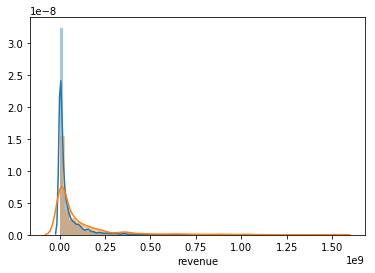

In [93]:
nullhomerev = df.loc[df['homepage'].isnull(), 'revenue']
homerev = df.loc[df['homepage'].notnull(), 'revenue']
sns.distplot(nullhomerev)
sns.distplot(homerev)
display(nullhomerev.describe())
display(homerev.describe())
hashomepage = np.array(df.homepage.isna(), dtype=int)
train['hashomepage'] = hashomepage

In [94]:
def df_transform(df):
    output = pd.DataFrame()
    output['hashomepage'] = np.array(df.homepage.isna(), dtype=int)
    output['budget'] = scaler.fit_transform(np.array(df['budget']).reshape(-1,1))
    to_lists(df,'cast')
    to_lists(df,'production_companies')
    to_lists(df,'genres')
    to_lists(df,'spoken_languages')
    list_one_hots(df,'spoken_languages',5,output)
    list_one_hots(df,'cast',20,output)
    list_one_hots(df,'production_companies',20,output)

In [6]:
df = df.drop('belongs_to_collection', axis = 1)

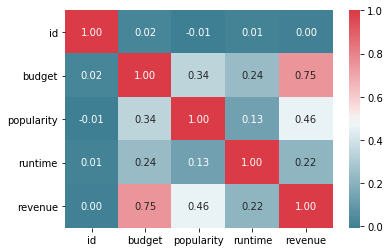

In [7]:
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.corr(), cmap=colormap, annot=True, fmt=".2f")


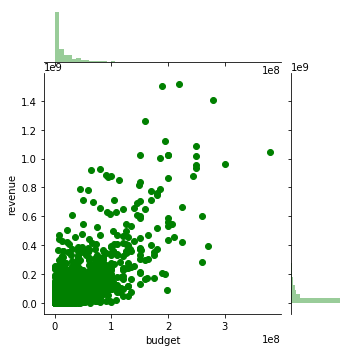

In [96]:
sns.jointplot(x="budget", y="revenue", data=df, height=5, ratio=4, color="g")
scaler = preprocessing.StandardScaler()
train['budget'] = scaler.fit_transform(np.array(df['budget']).reshape(-1,1))

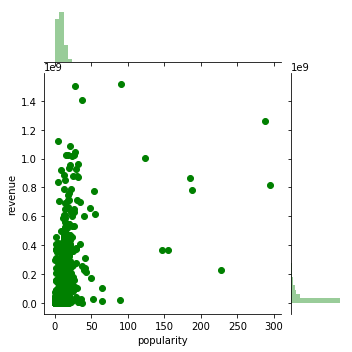

In [26]:
sns.jointplot(x="popularity", y="revenue", data=df, height=5, ratio=4, color="g")

In [10]:
df['runtime'] = df['runtime'].fillna(np.mean(df['runtime']))

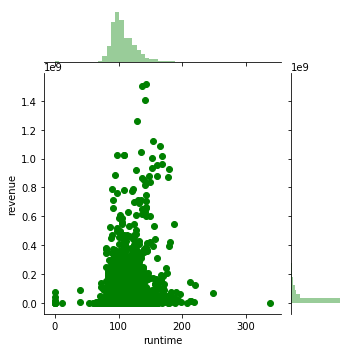

In [27]:
g = sns.jointplot(x='runtime', y="revenue", data=df, height=5, ratio=4, color="g")

In [12]:
def to_lists(df,col):
    dictionaries = df[col].apply(lambda x: {} if pd.isnull(x) else ast.literal_eval(x))
    for x in dictionaries.index:
        dictionaries[x] = [i['name'] for i in dictionaries[x]]
    df[col] = dictionaries
to_lists(df,'cast')
to_lists(df,'production_companies')
to_lists(df,'genres')
to_lists(df,'spoken_languages')

In [13]:
genres= set()
for genrelists in df['genres']:    
    for x in genrelists:
        genres.add(x)

In [14]:
for genre in genres:
    one_hot = [1 if genre in x else 0 for x in df['genres']]
    train[genre + ' one hot'] = one_hot

In [100]:
from collections import Counter
def list_one_hots(df,col,n,train):
    common = Counter([i for j in df[col] for i in j]).most_common(n)
    topNcompanies = [x for x,y in common]
    for N in topNcompanies:
        one_hot = [1 if N in x else 0 for x in df[col]]
        train[N + ' one hot'] = one_hot

list_one_hots(df,'spoken_languages',5,train)
list_one_hots(df,'cast',20,train)
list_one_hots(df,'production_companies',20,train)

In [16]:
languages = Counter([i for j in df['spoken_languages'] for i in j]).most_common(20)
train['num_spoken_languages']=df['spoken_languages'].apply(lambda x:len(x))

In [17]:
from sklearn.feature_selection import SelectKBest, f_classif,chi2
y = np.log(df['revenue'])

In [18]:
from datetime import datetime 
tofix = df['release_date'][0]
def datefixer(x):
    split_array = x.split('/')
    if int(split_array[2]) <= 19:
        split_array[2] = '20' + split_array[2]
    else:
        split_array[2] = '19' + split_array[2]
    x = '/'.join(split_array)
    return x
df['release_date'] = df['release_date'].apply(lambda x: datefixer(x))
df['release_date'] = df['release_date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))

In [19]:
month_one_hot = pd.get_dummies(df['release_date'].apply(lambda x:x.month))
for i in month_one_hot.columns:
    train['month_' + str(i)] = month_one_hot[i]
    train = train.drop('TV Movie one hot', axis = 1)

In [20]:
lgb_train = lgb.Dataset(train, y)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'num_leaves': 50,
    'learning_rate': 0.04,
    'bagging_fraction': 0.2,
    'feature_fraction':.2,
    'lambda_l2':.7,
    'metric':'rmse',
    'eval_at':15
}

In [65]:
print('Starting training...')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                )
print('Starting predicting...')
y_pred = gbm.predict(train, num_iteration=759)
print(pd.isnull(np.log(y_pred)).sum())
print('The rmse of prediction is:', mean_squared_error(y, y_pred) ** 0.5)

Starting training...
Starting predicting...
0
The rmse of prediction is: 1.8506881169144878


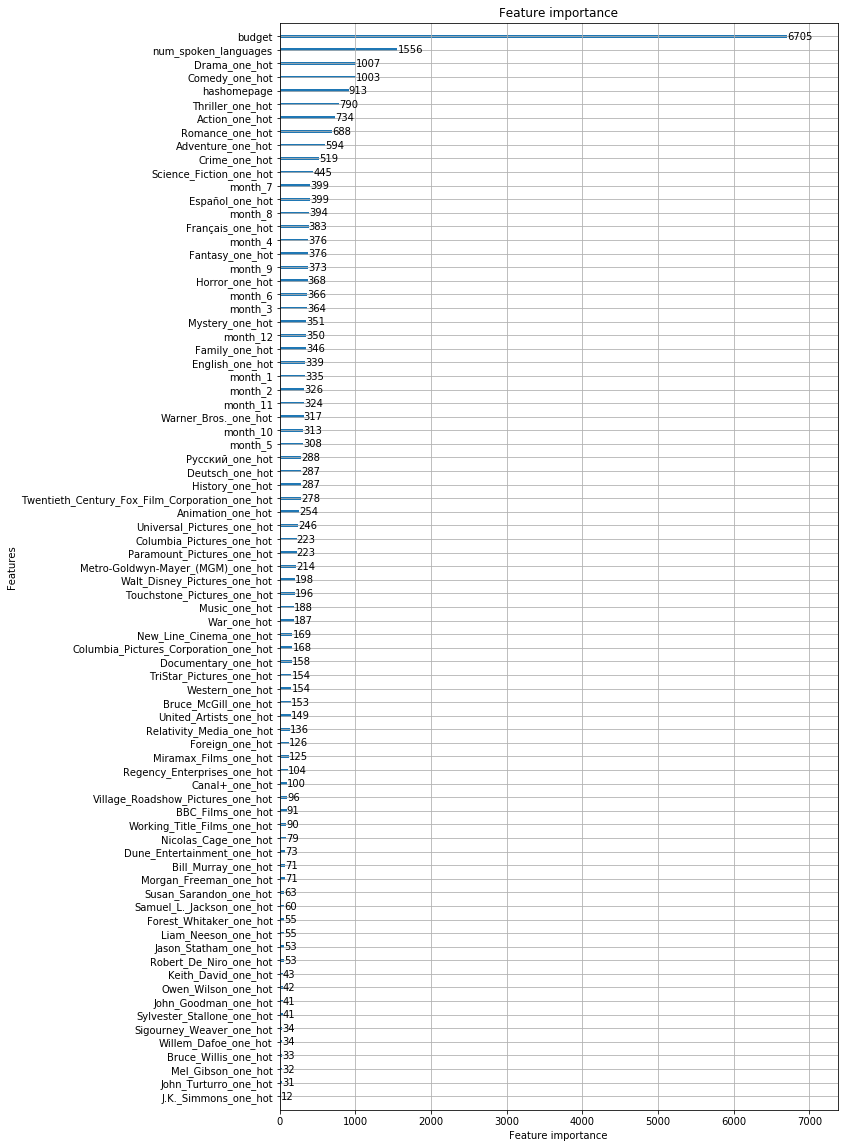

In [66]:
lgb.plot_importance(gbm,figsize = (10,20))

In [85]:
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'num_leaves': 100,
    'learning_rate': 0.009,
    'bagging_fraction': 0.1,
    'feature_fraction':.4,
    'lambda_l2':.1,
    'metric':'rmse',
}

In [91]:
for fold_n, (train_index, valid_index) in enumerate(folds.split(train)):
    print('fold ' + str(fold_n))
    lgb_train = lgb.Dataset(train.loc[train_index], y.loc[train_index])
    lgb_valid = lgb.Dataset(train.loc[valid_index], y.loc[valid_index])
    gbm = lgb.train(params,lgb_train,valid_sets = [lgb_valid],num_boost_round=1500,verbose_eval = 100)

fold 0
[100]	valid_0's rmse: 2.54595
[200]	valid_0's rmse: 2.34703
[300]	valid_0's rmse: 2.27912
[400]	valid_0's rmse: 2.24874
[500]	valid_0's rmse: 2.23813
[600]	valid_0's rmse: 2.23542
[700]	valid_0's rmse: 2.23519
[800]	valid_0's rmse: 2.23441
[900]	valid_0's rmse: 2.23678
[1000]	valid_0's rmse: 2.23762
[1100]	valid_0's rmse: 2.23992
[1200]	valid_0's rmse: 2.2395
[1300]	valid_0's rmse: 2.24136
[1400]	valid_0's rmse: 2.24149
[1500]	valid_0's rmse: 2.24445
fold 1
[100]	valid_0's rmse: 2.3783
[200]	valid_0's rmse: 2.15243
[300]	valid_0's rmse: 2.06767
[400]	valid_0's rmse: 2.03489
[500]	valid_0's rmse: 2.02483
[600]	valid_0's rmse: 2.02234
[700]	valid_0's rmse: 2.01873
[800]	valid_0's rmse: 2.01937
[900]	valid_0's rmse: 2.02108
[1000]	valid_0's rmse: 2.02439
[1100]	valid_0's rmse: 2.02809
[1200]	valid_0's rmse: 2.03237
[1300]	valid_0's rmse: 2.03551
[1400]	valid_0's rmse: 2.03897
[1500]	valid_0's rmse: 2.04096
fold 2
[100]	valid_0's rmse: 2.46388
[200]	valid_0's rmse: 2.29452
[300]	val